# Inference Graphs and Codecs for Machine Vision

In this workshop we will work through a custom deployment of a pre-trained PyTorch model.  We will use Resnet50 to perform image classification and return a predicted class and probability. We will also include some pre-processing functions that will require a custom deployment outside of using the pre-packaged PyTorch (Triton) server.  In order to create this deployment, the simplest and most flexible way is to use the MLServer custom wrapper.

In this workshop we will focus heavilty on encoding and decoding of data.  In particular, we will transfer data through the following stages:
1. JPG
2. Base64
3. Tensor
4. v2 protocol InferenceRequest
5. Tensors
6. v2 protocol InferenceResponse

An alternative approach is to deploy the model itself on top of Triton, and develop an MLServer custom wrapper for the pre-processor.  Seldon Core will handle the movement of input requests and output responses across the inference graph.  An open source contributor, Saeid Ghafouri, has created an excellent repo of examples called [seldon-inference-pipelines](https://github.com/saeid93/seldon-inference-pipelines).

## Setup

In [ ]:
!pip install mlserver
!pip install torchvision
!pip install Pillow

## Modeling Exploration and Testing

Download some jpeg images for exploration and testing

In [3]:
!gsutil cp -r gs://andrew-seldon/inference-graphs/images .

Copying gs://andrew-seldon/inference-graphs/images/pug.jpg...
Copying gs://andrew-seldon/inference-graphs/images/seldon_logo.jpg...           
Copying gs://andrew-seldon/inference-graphs/images/steel_crack.jpg...           
Copying gs://andrew-seldon/inference-graphs/images/tiny_seldon.jpg...           
/ [4 files][ 71.9 KiB/ 71.9 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://andrew-seldon/inference-graphs/images/vw_beetle.jpg...
- [5 files][325.7 KiB/325.7 KiB]                                                
Operation completed over 5 objects/325.7 KiB.                                    


Visualize one of the small, 8x8, images.  We will use this as an example to showcase the base64 string and the 3 dimensional torch tensor.

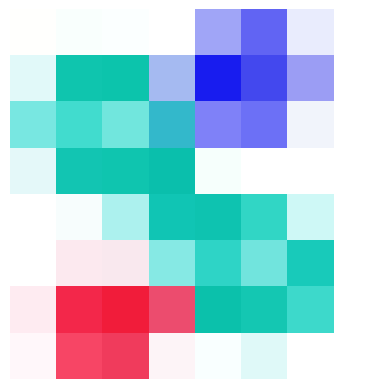

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./images/tiny_seldon.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

#### Base64 encoding
Create a function to read an image and encode it into a base64 string.  

This is useful to mimick the data format that will be passed in the request.  

We use the function to create a list of 5 base64 images to use as input.

In [6]:
from base64 import b64encode

def jpg_to_b64_string(path):

    # open image as a base64 byte string
    with open(path, "rb") as img_file:
        base64_bytes = b64encode(img_file.read())

    # encode as utf-8 string, as JSON cannot accept byte strings
    return base64_bytes.decode("utf-8")

b64_input = [
    jpg_to_b64_string("./images/tiny_seldon.jpg"),
    jpg_to_b64_string("./images/seldon_logo.jpg"),
    jpg_to_b64_string("./images/steel_crack.jpg"),
    jpg_to_b64_string("./images/vw_beetle.jpg"),
    jpg_to_b64_string("./images/pug.jpg")
]

print(f"Example base64 string\n{type(b64_input[0])}\n{b64_input[0]}\n")

Example base64 string
<class 'str'>
/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAAIAAgDAREAAhEBAxEB/8QAFAABAAAAAAAAAAAAAAAAAAAACv/EABsQAQEAAgMBAAAAAAAAAAAAAAYFBAcBAwgC/8QAFQEBAQAAAAAAAAAAAAAAAAAABwj/xAAbEQACAwEBAQAAAAAAAAAAAAADBQQGBwIBCP/aAAwDAQACEQMRAD8ARKPw8Zz7lgJu9Z6S9DH9JbtemIdg/wA71IB9S7Qv0Ms29Ov5CA/S16ymQINE1mdOaVZhy0cxGvfcoxk4CvNN32qs6kIWcaFTq9DqS3ixCXLrOVpXY8hyXlCXydEBXncvwBY/hZPJ/JIxhZddyjQj+mDLjQJ4ZnsGZfR3y3qdFXaassusZ39DdRNAzq0K7EN+1oamwsegmJbEKiXaRV5D7AapZUTxnLz5Fyur1nkVxARlCdp+f//Z



#### Base64 decoding
Create a function to decode a base64 string into a list of tensors.

This list of tensors can be passed into the PyTorch model.

In [8]:
from base64 import b64decode
from PIL import Image
from io import BytesIO
from torchvision.transforms import PILToTensor

def b64_string_to_tensor(b64_string: str):
    img_pil = Image.open(BytesIO(b64decode(b64_string)))
    img_tensor = PILToTensor()(img_pil)
    return img_tensor

tensor_input = [b64_string_to_tensor(b64_string) for b64_string in b64_input]

print(f"Example base64 string\n{type(tensor_input[0])}\n{tensor_input[0]}\n")

Example base64 string
<class 'torch.Tensor'>
tensor([[[255, 249, 251, 255, 160,  97, 233, 255],
         [225,  15,  12, 165,  24,  67, 155, 255],
         [120,  65, 113,  51, 127, 108, 241, 255],
         [228,  18,  15,  10, 246, 255, 255, 255],
         [255, 247, 172,  16,  14,  49, 206, 255],
         [255, 252, 249, 134,  46, 113,  24, 255],
         [254, 243, 241, 236,  11,  20,  61, 255],
         [255, 247, 240, 253, 249, 223, 255, 255]],

        [[255, 255, 255, 255, 165, 100, 236, 255],
         [249, 197, 196, 186,  28,  72, 157, 255],
         [231, 220, 230, 184, 129, 112, 244, 255],
         [248, 197, 197, 191, 255, 255, 255, 255],
         [255, 253, 241, 197, 195, 214, 248, 255],
         [255, 233, 232, 233, 212, 228, 202, 255],
         [235,  39,  28,  76, 193, 199, 217, 255],
         [247,  69,  59, 244, 255, 249, 255, 255]],

        [[253, 253, 255, 255, 247, 243, 253, 255],
         [249, 174, 172, 241, 239, 238, 244, 255],
         [225, 206, 221, 203, 248

#### Pretrained Resnet50 model
Instantiate a pre-trained resnet50 model with the default weights.  Create the required pre-processing function.

In [10]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).eval() 
preprocessor = weights.transforms()

Create a function to preprocesses our images.  Note that any custom code needed in the pre-processing stage can be input here, but we will use the custom transformations provided for the resnet50 model.

In [28]:
# show the resnet50 preprocessing steps
print(preprocessor)

def preprocess(img_tensor):
    # Apply inference preprocessing transforms
    return preprocessor(img_tensor).unsqueeze(0)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Create a function to classify the image and return a response in the form of {class}: {probability}

In [30]:
def classify(img_tensor):
    # Use the model and print the predicted category
    prediction = model(img_tensor).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    class_string = f"{category_name}: {100 * score:.1f}%"

    return class_string

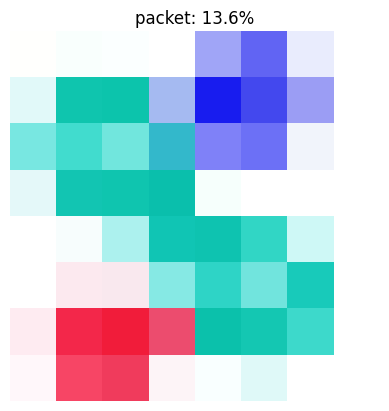

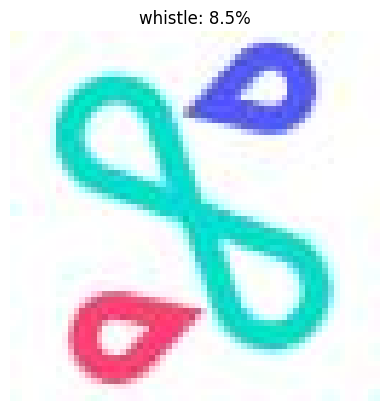

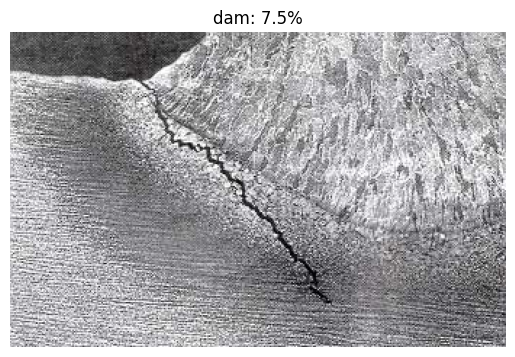

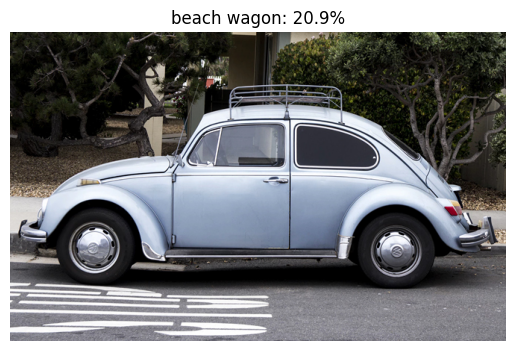

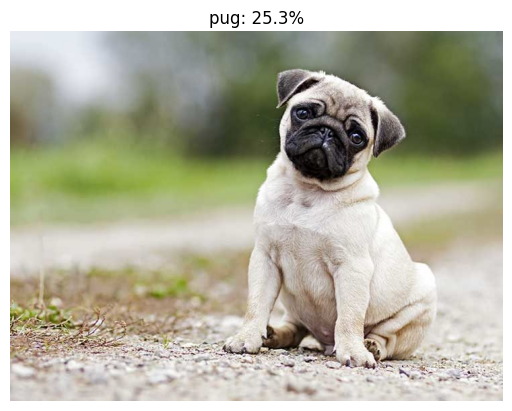

In [32]:
for img in tensor_input:
    
    classification = classify(preprocess(img))

    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(classification)
    plt.show()

## MLServer Codecs and Inference

[MLServer](https://mlserver.readthedocs.io/en/latest/) is an open source inference server that will turn your model in to a microservice with REST and gRPC endpoints.  MLServer has many benefits, including multi-model serving, parallel inference, adaptive batching, scaling support, and more.  Seldon uses MLServer to create production deployments on top of kubernetes.  

#### Encoding/Decoding Requests and Responses
MLServer uses the Open Inference Protocol (also known as the [v2 inference protocol](https://docs.seldon.io/projects/seldon-core/en/latest/reference/apis/v2-protocol.html)), which has been standardised and adopted by various model serving frameworks.  In this section, we will structure requests and responses in the format that MLServer expects.

Below, we will structure an MLServer **InferenceRequest** by providing a list of **RequestInputs**.  We will then print out the request object that we can use for inference.

In [33]:
from mlserver.types import InferenceRequest, RequestInput

v2_request = InferenceRequest(
  inputs=[RequestInput(
    name="input-1",
    shape=[1, 1],
    datatype="BYTES",
    data=b64_input[:1]
  )]
)

v2_request.dict()

{'inputs': [{'name': 'input-1',
   'shape': [1, 1],
   'datatype': 'BYTES',
   'data': ['/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAAIAAgDAREAAhEBAxEB/8QAFAABAAAAAAAAAAAAAAAAAAAACv/EABsQAQEAAgMBAAAAAAAAAAAAAAYFBAcBAwgC/8QAFQEBAQAAAAAAAAAAAAAAAAAABwj/xAAbEQACAwEBAQAAAAAAAAAAAAADBQQGBwIBCP/aAAwDAQACEQMRAD8ARKPw8Zz7lgJu9Z6S9DH9JbtemIdg/wA71IB9S7Qv0Ms29Ov5CA/S16ymQINE1mdOaVZhy0cxGvfcoxk4CvNN32qs6kIWcaFTq9DqS3ixCXLrOVpXY8hyXlCXydEBXncvwBY/hZPJ/JIxhZddyjQj+mDLjQJ4ZnsGZfR3y3qdFXaassusZ39DdRNAzq0K7EN+1oamwsegmJbEKiXaRV5D7AapZUTxnLz5Fyur1nkVxARlCdp+f//Z']}]}

Manually building request objects takes quite a bit of effort when all you have is a list of strings!  MLServer provides support for various [content-types](https://mlserver.readthedocs.io/en/latest/user-guide/content-type.html) that make the process of encoding common Python data types like pandas dataframes, numpy arrays, strings, etc. much quicker and easier.  In this case, we can make use of the [StringRequestCodec](https://mlserver.readthedocs.io/en/latest/user-guide/content-type.html#utf-8-string) to build the exact same request object with much less code. 

In [34]:
from mlserver.codecs.string import StringRequestCodec

# Encode an entire V2 request
v2_request = StringRequestCodec.encode_request(b64_input[:1], use_bytes=False)
v2_request.dict()

{'inputs': [{'name': 'input-1',
   'shape': [1, 1],
   'datatype': 'BYTES',
   'parameters': {'content_type': 'str'},
   'data': ['/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAAIAAgDAREAAhEBAxEB/8QAFAABAAAAAAAAAAAAAAAAAAAACv/EABsQAQEAAgMBAAAAAAAAAAAAAAYFBAcBAwgC/8QAFQEBAQAAAAAAAAAAAAAAAAAABwj/xAAbEQACAwEBAQAAAAAAAAAAAAADBQQGBwIBCP/aAAwDAQACEQMRAD8ARKPw8Zz7lgJu9Z6S9DH9JbtemIdg/wA71IB9S7Qv0Ms29Ov5CA/S16ymQINE1mdOaVZhy0cxGvfcoxk4CvNN32qs6kIWcaFTq9DqS3ixCXLrOVpXY8hyXlCXydEBXncvwBY/hZPJ/JIxhZddyjQj+mDLjQJ4ZnsGZfR3y3qdFXaassusZ39DdRNAzq0K7EN+1oamwsegmJbEKiXaRV5D7AapZUTxnLz5Fyur1nkVxARlCdp+f//Z']}]}

In order to decode the **InferenceRequest** into something usable by a model, we can use the same **StringRequestCodec** to decode the request into a list of strings.

In [35]:
b64_input_decoded = StringRequestCodec.decode_request(v2_request)
b64_input_decoded

['/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/2wBDAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQH/wAARCAAIAAgDAREAAhEBAxEB/8QAFAABAAAAAAAAAAAAAAAAAAAACv/EABsQAQEAAgMBAAAAAAAAAAAAAAYFBAcBAwgC/8QAFQEBAQAAAAAAAAAAAAAAAAAABwj/xAAbEQACAwEBAQAAAAAAAAAAAAADBQQGBwIBCP/aAAwDAQACEQMRAD8ARKPw8Zz7lgJu9Z6S9DH9JbtemIdg/wA71IB9S7Qv0Ms29Ov5CA/S16ymQINE1mdOaVZhy0cxGvfcoxk4CvNN32qs6kIWcaFTq9DqS3ixCXLrOVpXY8hyXlCXydEBXncvwBY/hZPJ/JIxhZddyjQj+mDLjQJ4ZnsGZfR3y3qdFXaassusZ39DdRNAzq0K7EN+1oamwsegmJbEKiXaRV5D7AapZUTxnLz5Fyur1nkVxARlCdp+f//Z']

Putting this all together, can now:
* create an inference request
* decode the request
* convert to torch tensors
* preprocess the images
* make a prediction using the model

In [46]:
# create an inference request
inference_request = StringRequestCodec.encode_request(b64_input, use_bytes=False)

# decode the request
b64_input = StringRequestCodec.decode_request(v2_request)

# convert to torch tensors
tensor_input = [b64_string_to_tensor(b64) for b64 in b64_input]

# preprocess the images
preprocessed_input = [preprocess(img_tensor) for img_tensor in tensor_input]

# make a prediction using the model
outputs = [classify(img_tensor) for img_tensor in preprocessed_input]

outputs

['packet: 13.6%',
 'whistle: 8.5%',
 'dam: 7.5%',
 'beach wagon: 20.9%',
 'pug: 25.3%']

MLServer expects that the response will be structured as a **ResponseOutput** object which includes a list of **ResponseOutputs**.  We strucure this manually below:

In [64]:
from mlserver.types import InferenceResponse, ResponseOutput
import uuid

response = InferenceResponse(
    model_name="model_name",
    model_version="model_version",
    id=str(uuid.uuid4()),
    outputs=[ResponseOutput(
        name="output-1",
        shape=[5, 1],
        datatype="BYTES",
        data=outputs
    )]
)

response

InferenceResponse(model_name='model_name', model_version='model_version', id='2fd12641-2a19-4bd9-ae9e-4538500d97f7', parameters=None, outputs=[ResponseOutput(name='output-1', shape=[5, 1], datatype='BYTES', parameters=None, data=TensorData(__root__=['packet: 13.6%', 'whistle: 8.5%', 'dam: 7.5%', 'beach wagon: 20.9%', 'pug: 25.3%']))])

Becaue this requires a lot of effort to encode a response object from a simple list of strings, we use again use the **StringRequestCodec** to make this easier:

In [65]:
response = StringRequestCodec.encode_response(
    model_name="model_name",
    model_version="model_version",
    payload=outputs
    )
    
response

InferenceResponse(model_name='model_name', model_version='model_version', id=None, parameters=None, outputs=[ResponseOutput(name='output-1', shape=[5, 1], datatype='BYTES', parameters=Parameters(content_type='str', headers=None), data=TensorData(__root__=[b'packet: 13.6%', b'whistle: 8.5%', b'dam: 7.5%', b'beach wagon: 20.9%', b'pug: 25.3%']))])

### MLSever Custom Wrapper & Local Testing

Now that we've built the logic for our model, we can create an MLServer custom wrapper and the associated settings filed in order to serve and test it.

The [settings.json](https://mlserver.readthedocs.io/en/latest/reference/settings.html) holds the configuration of our server (e.g. ports, log level, etc.).

In [41]:
%%writefile settings.json
{
    "debug": "true"
}

Overwriting settings.json


The [model-settings.json](https://mlserver.readthedocs.io/en/latest/reference/model-settings.html) holds the configuration of our model (e.g. input type, runtime to use, etc.).  The implementation includes the name of the Python module and the class for the custom wrapper.

In [67]:
%%writefile model-settings.json
{
    "name": "simple-mlserver",
    "implementation": "model.CustomModel"
}

Overwriting model-settings.json


The custom wrapper is a python file that contains a class for the custom deployment (it can be named anything you like).  The class inherits the MLModel class from MLServer, and has two key async methods:
* `load(self) -> bool`: Responsible for loading any artifacts related to a model (e.g. model weights, pickle files, etc.).
* `predict(self, payload: InferenceRequest) -> InferenceResponse`: Responsible for using a model to perform inference on an incoming data point.

In [54]:
%%writefile model.py
from base64 import b64decode
from PIL import Image
from io import BytesIO

from mlserver import MLModel
from mlserver.types import InferenceRequest, InferenceResponse
from mlserver.codecs.string import StringRequestCodec, StringCodec
from mlserver.logging import logger

from torchvision.transforms import PILToTensor
from torchvision.models import resnet50, ResNet50_Weights

class CustomModel(MLModel):

  async def load(self) -> bool:
        
    self._weights = ResNet50_Weights.DEFAULT
    
    self._model = resnet50(weights=self._weights).eval() 

    self._preprocessor = self._weights.transforms()
     
    self.ready = True
    return self.ready

  async def predict(self, payload: InferenceRequest) -> InferenceResponse:

    # Decode request
    b64_input = StringRequestCodec.decode_request(payload)

    # Base64 to tensor
    tensor_input = [self.b64_string_to_tensor(b64) for b64 in b64_input]

    # Preprocess images
    preprocessed_input = [self.preprocess(img_tensor) for img_tensor in tensor_input]
    
    # Classify images
    outputs = [self.classify(img_tensor) for img_tensor in preprocessed_input]
    # logger.info(outputs)

    # Construct the response
    response = StringRequestCodec.encode_response(
      model_name=self.name,
      model_version=self.version,
      payload=outputs
    )

    return response

  def b64_string_to_tensor(self, b64_string: str):
    # Convert the images from base64 strings to torch tensors 
    img_pil = Image.open(BytesIO(b64decode(b64_string)))
    img_tensor = PILToTensor()(img_pil)
    return img_tensor

  def preprocess(self, img_tensor):
    # Apply inference preprocessing transforms
     return self._preprocessor(img_tensor).unsqueeze(0)

  def classify(self, img_tensor):
    # Use the model and get the predicted category
    prediction = self._model(img_tensor).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = self._weights.meta["categories"][class_id]
    class_string = f"{category_name}: {100 * score:.1f}%"

    return class_string

Overwriting model.py


You can now run `mlserver start .` from this directory to start serving your custom model

Here we create a simple client to make a request to the model, using the same `inference_request` we created earlier.

In [55]:
import requests
import json

endpoint = "http://localhost:8080/v2/models/simple-mlserver/infer"
response = requests.post(endpoint, json=inference_request.dict())
print(json.dumps(response.json(), indent=2))

{
  "model_name": "simple-mlserver",
  "model_version": null,
  "id": "6669655c-5bac-4261-92b3-a4e02c125a29",
  "parameters": {
    "content_type": null,
    "headers": null
  },
  "outputs": [
    {
      "name": "output-1",
      "shape": [
        5,
        1
      ],
      "datatype": "BYTES",
      "parameters": {
        "content_type": "str",
        "headers": null
      },
      "data": [
        "packet: 13.6%",
        "whistle: 8.5%",
        "dam: 7.5%",
        "beach wagon: 20.9%",
        "pug: 25.3%"
      ]
    }
  ]
}


You should see a `200` response with the parsed response object.  Looks like everything is working!  You can now type `ctrl + c` in the shell to shut down MLServer.

## Model Deployment

Now that we have written and tested our custom model, the next step is to deploy it. With that goal in mind, the rough outline of steps will be to first build a custom image containing our code, and then deploy it using the SDK.

#### Building a custom image
MLServer offers helpers to build a custom Docker image containing your code. In this example, we will use the mlserver build subcommand to create an image, which we’ll be able to deploy later.

> NOTE that these steps aren't necessary for the purpose of the demo, as the image has already been created and pushed to Docker Hub.  If you choose to proceed, this section expects that Docker is available and running in the background.

In the project directory we will run:

> `mlserver build . -t anddwilson/inference-graphs-custom-wrapper:0.1`

To ensure that the image is fully functional, we can spin up a container and then send a test request. To start the container, you can run the following in a separate terminal:

> `docker run -test --rm -p 8080:8080 anddwilson/inference-graphs-custom-wrapper:0.1`

We can then test sending requests again using the above request.

Finally, we can push our image to a docker registry, in this case we will just push it to Docker Hub (NOTE: you may want to skip this step, as there is already an image pushed to the Docker Hub):

> `docker push anddwilson/inference-graphs-custom-wrapper:0.1`

Now that we’ve built a custom image and verified that it works as expected, we can move to the next step and deploy it.

#### Deploying through the UI

We will deploy the model using the UI for this session, so we will jump over there now.

A few things to note:

* Set the Protocol to V2 Inference.
* Set the Runtime to Custom.
* Set the Docker Image to `anddwilson/inference-graphs-custom-wrapper:0.1`.
* **IMPORTANT!!!** Set a custom environment variable to enable torch hub to download the model to a working directory:
  * Variable: `TORCH_HOME`
  * Value: `/opt/mlserver/torch`
* Set CPU Requests and Limits to 1
* Set Memory Request and Limits to 2Gi

Once your model is deployed, you can run an inference request in the Seldon Deploy UI to see if it's working.  You can run this script to generate a json inference request file:

In [58]:
import json
with open('request.json', 'w') as fp:
    json.dump(inference_request.dict(), fp)

#### Deploying via the SDK

The model can also be deployed programatically via the SDK.

Import the necessary classes from seldon_deploy_sdk

In [60]:
from seldon_deploy_sdk import Configuration, EnvironmentApi, ApiClient, PredictApi, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition, OutlierDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator
from seldon_deploy_sdk.rest import ApiException

Create an auth() function for the api client

***IMPORTANT!!!*** please replace the `SD_IP` below with the IP of your cluster:  

In [61]:
SD_IP = "XXXXX"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Specify the SeldonDeployment JSON.  You can change the name of your deployment, the namespace, and the image.

In [63]:
DEPLOYMENT_NAME = "simple-mlserver"
NAMESPACE = "seldon"
IMAGE = "anddwilson/inference-graphs-custom-wrapper:0.1"

seldon_deployment = {
	"kind": "SeldonDeployment",
	"metadata": {
		"name": DEPLOYMENT_NAME,
		"namespace": NAMESPACE,
		"labels": {
			"fluentd": "true"
		}
	},
	"apiVersion": "machinelearning.seldon.io/v1",
	"spec": {
		"name": DEPLOYMENT_NAME,
		"annotations": {
			"seldon.io/engine-seldon-log-messages-externally": "true"
		},
		"protocol": "v2",
		"predictors": [
			{
				"componentSpecs": [
					{
						"spec": {
							"containers": [
								{
									"name": f"{DEPLOYMENT_NAME}-container",
									"env": [
										{
											"name": "TORCH_HOME",
											"value": "/opt/mlserver/torch"
										}
									],
									"image": IMAGE,
									"resources": {
										"requests": {
											"cpu": "1",
											"memory": "2Gi",
											"nvidia.com/gpu": "0"
										},
										"limits": {
											"cpu": "1",
											"memory": "2Gi",
											"nvidia.com/gpu": "0"
										}
									}
								}
							]
						}
					}
				],
				"name": "default",
				"replicas": 1,
				"traffic": 100,
				"graph": {
					"type": "MODEL",
					"name": f"{DEPLOYMENT_NAME}-container",
					"parameters": [],
					"children": [],
					"logger": {
						"mode": "all"
					}
				},
				"annotations": {
					f"project.seldon.io/{DEPLOYMENT_NAME}-container": "default"
				}
			}
		]
	}
}

Call the `create_seldon_deployment` method to deploy the model programatically

In [64]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=seldon_deployment)

{'api_version': None,
 'kind': None,
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': '2022-11-30T14:21:40Z',
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': 1,
              'labels': {'fluentd': 'true'},
              'managed_fields': [{'api_version': 'machinelearning.seldon.io/v1',
                                  'fields_type': 'FieldsV1',
                                  'fields_v1': {'f:metadata': {'f:labels': {'.': {},
                                                                            'f:fluentd': {}}},
                                                'f:spec': {'.': {},
                                                           'f:annotations': {'.': {},
                                                                             'f:seldon.io/engine-seldon-log-messag

Below we show how the `infer` model endpoint. 

In [65]:
endpoint = f"http://{SD_IP}/seldon/{NAMESPACE}/{DEPLOYMENT_NAME}/v2/models/{DEPLOYMENT_NAME}-container/infer"
endpoint

'http://34.74.124.230/seldon/seldon/simple-mlserver/v2/models/simple-mlserver-container/infer'

We can create a request and view the response:

In [66]:
response = requests.post(endpoint, json=inference_request.dict())
print(json.dumps(response.json(), indent=2))

{
  "model_name": "simple-mlserver-container",
  "model_version": null,
  "id": "b94eda97-813c-4cb8-bf0a-66d3eddd64ab",
  "parameters": {
    "content_type": null,
    "headers": null
  },
  "outputs": [
    {
      "name": "output-1",
      "shape": [
        5,
        1
      ],
      "datatype": "BYTES",
      "parameters": {
        "content_type": "str",
        "headers": null
      },
      "data": [
        "packet: 13.6%",
        "whistle: 8.5%",
        "dam: 7.5%",
        "beach wagon: 20.9%",
        "pug: 25.3%"
      ]
    }
  ]
}


## Well done!

You've deployed a PyTorch model using Seldon by creating your own custom wrapper using MLServer.  Along the way, hopefully you learned a bit about encoding and deocoding!

Here are some potential ideas to test alternative approaches:
* Load in a serialized torchscript model into the wrapper, as opposed to using the model hub
* Deploy the model using Triton, and use a custom MLServer wrapper for the preprocessing steps
* Deploy and image segmentation model using Triton with pre- and post-processors as MLServer custom wrappers
* Try and deploy the model fully in Triton, experimenting with TensorRT, Ensembling, and GPUs
* Use gRPC requests instead of REST
* Load testing and auto-scaling the model
* Bonus: model optimization (e.g. quantization, removing base64)